In [1]:
!pip install tensorflow opencv-python matplotlib tqdm


In [2]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [3]:

zip_path=r'C:\Users\LENOVO\Desktop\AI\Bipolar_factory\object_detection_dataset.zip'
extract_path=r'C:\Users\LENOVO\Desktop\AI\Bipolar_factory\object_detection_dataset'

with zipfile.ZipFile(zip_path,'r')as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to",extract_path)

Dataset extracted to C:\Users\LENOVO\Desktop\AI\Bipolar_factory\object_detection_dataset


In [4]:
for file in os.listdir():
    print(file)

.ipynb_checkpoints
dataset
object_detection.ipynb
object_detection_dataset
object_detection_dataset.zip


In [5]:
split='train'

image_dir=os.path.join(extract_path,split,'images')
label_dir=os.path.join(extract_path,split,'labels')

image_paths=[]
for fname in sorted(os.listdir(image_dir)):
    if fname.endswith('.jpg'):
        image_paths.append(os.path.join(image_dir,fname))

label_paths=[]
for img_path in image_paths:
    filename=os.path.splitext(os.path.basename(img_path))[0]
    label_paths.append(os.path.join(label_dir,filename + '.txt'))


print(f"Number of images in {split}: {len(image_paths)}")
print(f"Number of labels in {split}: {len(label_paths)}")

Number of images in train: 168
Number of labels in train: 168


In [6]:
split='test'

image_dir=os.path.join(extract_path,split,'images')
label_dir=os.path.join(extract_path,split,'labels')

image_paths=[]
for fname in sorted(os.listdir(image_dir)):
    if fname.endswith('.jpg'):
        image_paths.append(os.path.join(image_dir,fname))

label_paths=[]
for img_path in image_paths:
    filename=os.path.splitext(os.path.basename(img_path))[0]
    label_paths.append(os.path.join(label_dir,filename + '.txt'))


print(f"Number of images in {split}: {len(image_paths)}")
print(f"Number of labels in {split}: {len(label_paths)}")
  

Number of images in test: 9
Number of labels in test: 9


In [7]:
split='valid'

image_dir=os.path.join(extract_path,split,'images')
label_dir=os.path.join(extract_path,split,'labels')

image_paths=[]
for fname in sorted(os.listdir(image_dir)):
    if fname.endswith('.jpg'):
        image_paths.append(os.path.join(image_dir,fname))

label_paths=[]
for img_path in image_paths:
    filename=os.path.splitext(os.path.basename(img_path))[0]
    label_paths.append(os.path.join(label_dir,filename + '.txt'))


print(f"Number of images in {split}: {len(image_paths)}")
print(f"Number of labels in {split}: {len(label_paths)}")
  

Number of images in valid: 22
Number of labels in valid: 22


In [8]:
def load_preprocess_sample(img_path, label_path):
    # Load image with OpenCV and convert BGR to RGB
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0  # normalize pixels to [0,1]

    # Load label: expect first line to be: class x_center y_center width height (normalized)
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    if not lines:
        # No object in image; label all zeros
        label = np.zeros(5)
    else:
        label = np.array(list(map(float, lines[0].strip().split())))

    return img, label

In [9]:
def simple_data_generator(img_folder, label_folder, batch_size=8):
    img_files = sorted(os.listdir(img_folder))
    label_files = sorted(os.listdir(label_folder))

    while True:
        imgs = []
        labels = []
        for _ in range(batch_size):
            idx = np.random.randint(len(img_files))
            img_path = os.path.join(img_folder, img_files[idx])
            label_path = os.path.join(label_folder, label_files[idx])

            img, label = load_preprocess_sample(img_path, label_path)
            imgs.append(img)
            labels.append(label)
        
        yield np.array(imgs), np.array(labels)

In [10]:
IMG_SIZE = 224
import tensorflow as tf
from tensorflow.keras import layers, models

base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze backbone initially

def create_model():
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(5, activation='sigmoid')(x)  # [class, x, y, w, h]
    return models.Model(inputs, outputs)

model = create_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
model.compile(optimizer='adam', loss='mse')

In [12]:
batch_size = 8

train_gen = simple_data_generator('./dataset/train/images', './dataset/train/labels', batch_size)
valid_gen = simple_data_generator('./dataset/valid/images', './dataset/valid/labels', batch_size)

steps_per_epoch = len(os.listdir('./dataset/train/images')) // batch_size
validation_steps = len(os.listdir('./dataset/valid/images')) // batch_size

history = model.fit(train_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    validation_data=valid_gen,
                    validation_steps=validation_steps)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - loss: 31.1392 - val_loss: 23.3351
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - loss: 26.3901 - val_loss: 23.3283
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - loss: 21.5271 - val_loss: 23.3401
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - loss: 24.2218 - val_loss: 23.3364
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - loss: 27.2690 - val_loss: 23.3271
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - loss: 27.0540 - val_loss: 23.3297
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - loss: 27.4163 - val_loss: 23.3279
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - loss: 24.4480 - val_loss: 23.3276
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - loss: 21.8872 - val_loss: 23.3258
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - loss: 26.8673 - val_loss: 23.3265


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


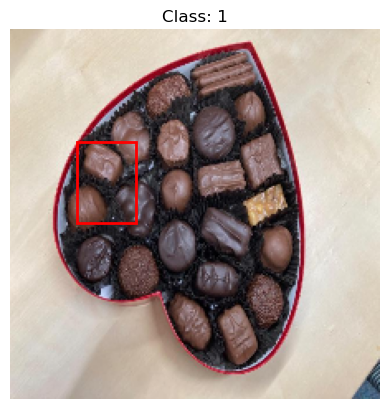

In [13]:
import matplotlib.pyplot as plt
def plot_prediction(img, pred):
    # pred: [class, x_center, y_center, w, h] all normalized
    img = img.copy()
    h, w, _ = img.shape
    cls, x_c, y_c, bw, bh = pred

    # Convert to pixel coords
    x1 = int((x_c - bw / 2) * w)
    y1 = int((y_c - bh / 2) * h)
    x2 = int((x_c + bw / 2) * w)
    y2 = int((y_c + bh / 2) * h)

    plt.imshow(img)
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                      fill=False, edgecolor='red', linewidth=2))
    plt.title(f'Class: {int(cls)}')
    plt.axis('off')
    plt.show()

# Get one sample
img_path = './dataset/test/images/' + os.listdir('./dataset/test/images')[1]
lbl_path = './dataset/test/labels/' + os.listdir('./dataset/test/labels')[1]
img, _ = load_preprocess_sample(img_path, lbl_path)

pred = model.predict(img[np.newaxis, ...])[0]
plot_prediction((img*255).astype(np.uint8), pred)


In [26]:
model.save('object_detection_model.keras')

In [30]:
# Prediction format: [class_id, center_x, center_y, width, height]
_, x_center, y_center, width, height = pred

# Convert to pixel coordinates
img_h, img_w, _ = img.shape
x_center *= img_w
y_center *= img_h
width *= img_w
height *= img_h

x_min = int(x_center - width / 2)
y_min = int(y_center - height / 2)
x_max = int(x_center + width / 2)
y_max = int(y_center + height / 2)

pred_box = [x_min, y_min, x_max, y_max]

In [33]:
label_path = test_lbl_path
img_path = test_img_path

# Read image
img = cv2.imread(img_path)
if img is None:
    print(f"Could not load image: {img_path}")
else:
    with open(label_path, 'r') as f:
        line = f.readline().strip().split()
        class_id, x_center, y_center, width, height = map(float, line)

    # Convert to pixel coordinates
    x_center *= img.shape[1]
    y_center *= img.shape[0]
    width *= img.shape[1]
    height *= img.shape[0]

    x_min = int(x_center - width / 2)
    y_min = int(y_center - height / 2)
    x_max = int(x_center + width / 2)
    y_max = int(y_center + height / 2)

    gt_box = [x_min, y_min, x_max, y_max]
    print("Ground truth box (pixels):", gt_box)

Ground truth box (pixels): [183, 372, 261, 462]


In [34]:
def calculate_iou(box1, box2):
    # box format: [x1, y1, x2, y2]
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)
    inter_area = max((xi2 - xi1), 0) * max((yi2 - yi1), 0)

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area != 0 else 0

def evaluate_model(test_images, test_labels, model, iou_threshold=0.5):
    TP, FP, FN = 0, 0, 0

    for img_path, label_path in zip(test_images, test_labels):
        img = cv2.imread(img_path)

        if img is None:
            print(f"[Warning] Could not load image: {img_path}")
            continue

        H, W = img.shape[:2]
        img_resized = cv2.resize(img, (224, 224)) / 255.0
        input_img = np.expand_dims(img_resized, axis=0)

        pred = model.predict(input_img)[0]

        # Convert predicted bounding box from normalized format
        pred_box = [
            int(pred[0] * W),
            int(pred[1] * H),
            int((pred[0] + pred[2]) * W),
            int((pred[1] + pred[3]) * H)
        ]

        # Read ground truth label (YOLO format)
        with open(label_path, 'r') as f:
            line = f.readline().split()
            x_center, y_center, width, height = map(float, line[1:])
            x1 = int((x_center - width / 2) * W)
            y1 = int((y_center - height / 2) * H)
            x2 = int((x_center + width / 2) * W)
            y2 = int((y_center + height / 2) * H)
            gt_box = [x1, y1, x2, y2]

        iou = calculate_iou(pred_box, gt_box)

        if iou >= iou_threshold:
            TP += 1
        else:
            FP += 1
            FN += 1

    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")

In [36]:
test_images = sorted(os.listdir('./dataset/test/images'))
test_labels = sorted(os.listdir('./dataset/test/labels'))

test_img_path = './dataset/test/images/' + test_images[1]
test_lbl_path = './dataset/test/labels/' + test_labels[1]

In [37]:
evaluate_model([test_img_path], [test_lbl_path], model)
print(f"Predicted box (normalized): {pred}")
print(f"Predicted box (scaled): {pred_box}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Precision: 0.00
Recall: 0.00
Predicted box (normalized): [1.         0.26215404 0.41505882 0.16073513 0.21842182]
Predicted box (scaled): [40, 68, 76, 117]
